In [1]:
##from https://github.com/eriklindernoren/Keras-GAN/blob/master/infogan/infogan.py


from __future__ import print_function, division

from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Input, Dense, Reshape, Flatten, Dropout, multiply, concatenate
from tensorflow.keras.layers import BatchNormalization, Activation, Embedding, ZeroPadding2D, Lambda
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import UpSampling2D, Conv2D
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
import tensorflow.python.keras.backend as K

import matplotlib.pyplot as plt

import numpy as np

from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Geometry import Point3D

from tqdm import tqdm_notebook

from scipy.spatial.distance import pdist
from scipy.spatial.distance import squareform

import numpy as np

from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA

import matplotlib.pyplot as plt
%matplotlib inline


RDKit WARNING: [07:50:11] Enabling RDKit 2019.09.1 jupyter extensions


Implement INFOGAN https://arxiv.org/pdf/1606.03657.pdf
Unsupervised feature learning by maximising the mutual information of noise vector inputs

In [3]:


class INFOGAN():
    def __init__(self):
        self.img_rows = 28
        self.img_cols = 28
        self.channels = 1
        self.num_classes = 10
        self.img_shape = (self.img_rows, self.img_cols, self.channels)
        self.latent_dim = 72


        optimizer = Adam(0.0002, 0.5)
        losses = ['binary_crossentropy', self.mutual_info_loss]

        # Build and the discriminator and recognition network
        self.discriminator, self.auxilliary = self.build_disk_and_q_net()

        self.discriminator.compile(loss=['binary_crossentropy'],
            optimizer=optimizer,
            metrics=['accuracy'])

        # Build and compile the recognition network Q
        self.auxilliary.compile(loss=[self.mutual_info_loss],
            optimizer=optimizer,
            metrics=['accuracy'])

        # Build the generator
        self.generator = self.build_generator()

        # The generator takes noise and the target label as input
        # and generates the corresponding digit of that label
        gen_input = Input(shape=(self.latent_dim,))
        img = self.generator(gen_input)

        # For the combined model we will only train the generator
        self.discriminator.trainable = False

        # The discriminator takes generated image as input and determines validity
        valid = self.discriminator(img)
        # The recognition network produces the label
        target_label = self.auxilliary(img)

        # The combined model  (stacked generator and discriminator)
        self.combined = Model(gen_input, [valid, target_label])
        self.combined.compile(loss=losses,
            optimizer=optimizer)


    def build_generator(self):

        model = Sequential()

        model.add(Dense(128 * 7 * 7, activation="relu", input_dim=self.latent_dim))
        model.add(Reshape((7, 7, 128)))
        model.add(BatchNormalization(momentum=0.8))
        model.add(UpSampling2D())
        model.add(Conv2D(128, kernel_size=3, padding="same"))
        model.add(Activation("relu"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(UpSampling2D())
        model.add(Conv2D(64, kernel_size=3, padding="same"))
        model.add(Activation("relu"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Conv2D(self.channels, kernel_size=3, padding='same'))
        model.add(Activation("tanh"))

        gen_input = Input(shape=(self.latent_dim,))
        img = model(gen_input)

        model.summary()

        return Model(gen_input, img)


    def build_disk_and_q_net(self):

        img = Input(shape=self.img_shape)

        # Shared layers between discriminator and recognition network
        model = Sequential()
        model.add(Conv2D(64, kernel_size=3, strides=2, input_shape=self.img_shape, padding="same"))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(Conv2D(128, kernel_size=3, strides=2, padding="same"))
        model.add(ZeroPadding2D(padding=((0,1),(0,1))))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Conv2D(256, kernel_size=3, strides=2, padding="same"))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Conv2D(512, kernel_size=3, strides=2, padding="same"))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Flatten())

        img_embedding = model(img)

        # Discriminator
        validity = Dense(1, activation='sigmoid')(img_embedding)

        # Recognition
        q_net = Dense(128, activation='relu')(img_embedding)
        label = Dense(self.num_classes, activation='softmax')(q_net)

        # Return discriminator and recognition network
        return Model(img, validity), Model(img, label)


    def mutual_info_loss(self, c, c_given_x):
        """The mutual information metric we aim to minimize"""
        eps = 1e-8
        conditional_entropy = K.mean(- K.sum(K.log(c_given_x + eps) * c, axis=1))
        entropy = K.mean(- K.sum(K.log(c + eps) * c, axis=1))

        return conditional_entropy + entropy

    def sample_generator_input(self, batch_size):
        # Generator inputs
        sampled_noise = np.random.normal(0, 1, (batch_size, 62))
        sampled_labels = np.random.randint(0, self.num_classes, batch_size).reshape(-1, 1)
        sampled_labels = to_categorical(sampled_labels, num_classes=self.num_classes)

        return sampled_noise, sampled_labels

    def train(self, epochs, batch_size=128, sample_interval=50):

        # Load the dataset
        (X_train, y_train), (_, _) = (square_edm[:180],np.ones(180)),(square_edm[180:], np.ones(20))

        # Rescale -1 to 1
#         X_train = (X_train.astype(np.float32) - 127.5) / 127.5
        X_train = np.expand_dims(X_train, axis=3)
        y_train = y_train.reshape(-1, 1)

        # Adversarial ground truths
        valid = np.ones((batch_size, 1))
        fake = np.zeros((batch_size, 1))

        for epoch in range(epochs):

            # ---------------------
            #  Train Discriminator
            # ---------------------

            # Select a random half batch of images
            idx = np.random.randint(0, X_train.shape[0], batch_size)
            imgs = X_train[idx]

            # Sample noise and categorical labels
            sampled_noise, sampled_labels = self.sample_generator_input(batch_size)
            gen_input = np.concatenate((sampled_noise, sampled_labels), axis=1)

            # Generate a half batch of new images
            gen_imgs = self.generator.predict(gen_input)

            # Train on real and generated data
            d_loss_real = self.discriminator.train_on_batch(imgs, valid)
            d_loss_fake = self.discriminator.train_on_batch(gen_imgs, fake)

            # Avg. loss
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

            # ---------------------
            #  Train Generator and Q-network
            # ---------------------

            g_loss = self.combined.train_on_batch(gen_input, [valid, sampled_labels])

            # Plot the progress
            print ("%d [D loss: %.2f, acc.: %.2f%%] [Q loss: %.2f] [G loss: %.2f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss[1], g_loss[2]))

            # If at save interval => save generated image samples
            if epoch % sample_interval == 0:
                self.sample_images(epoch)

    def sample_images(self, epoch):
        r, c = 10, 10

        fig, axs = plt.subplots(r, c)
        for i in range(c):
            sampled_noise, _ = self.sample_generator_input(c)
            label = to_categorical(np.full(fill_value=i, shape=(r,1)), num_classes=self.num_classes)
            gen_input = np.concatenate((sampled_noise, label), axis=1)
            gen_imgs = self.generator.predict(gen_input)
            gen_imgs = 0.5 * gen_imgs + 0.5
            for j in range(r):
                axs[j,i].imshow(gen_imgs[j,:,:,0], cmap='gray')
                axs[j,i].axis('off')
        fig.savefig("images/%d.png" % epoch)
        plt.close()

    def save_model(self):

        def save(model, model_name):
            model_path = "saved_model/%s.json" % model_name
            weights_path = "saved_model/%s_weights.hdf5" % model_name
            options = {"file_arch": model_path,
                        "file_weight": weights_path}
            json_string = model.to_json()
            open(options['file_arch'], 'w').write(json_string)
            model.save_weights(options['file_weight'])

        save(self.generator, "generator")
        save(self.discriminator, "discriminator")


In [4]:
model=Sequential()

In [6]:
cd Downloads

C:\Users\harry\Downloads


In [7]:
mols = list()
smiles = [i.strip('\n') for i in open('gdb13.smi', 'r').readlines()]
for smi in tqdm_notebook(smiles):
    mols.append(Chem.MolFromSmiles(smi))

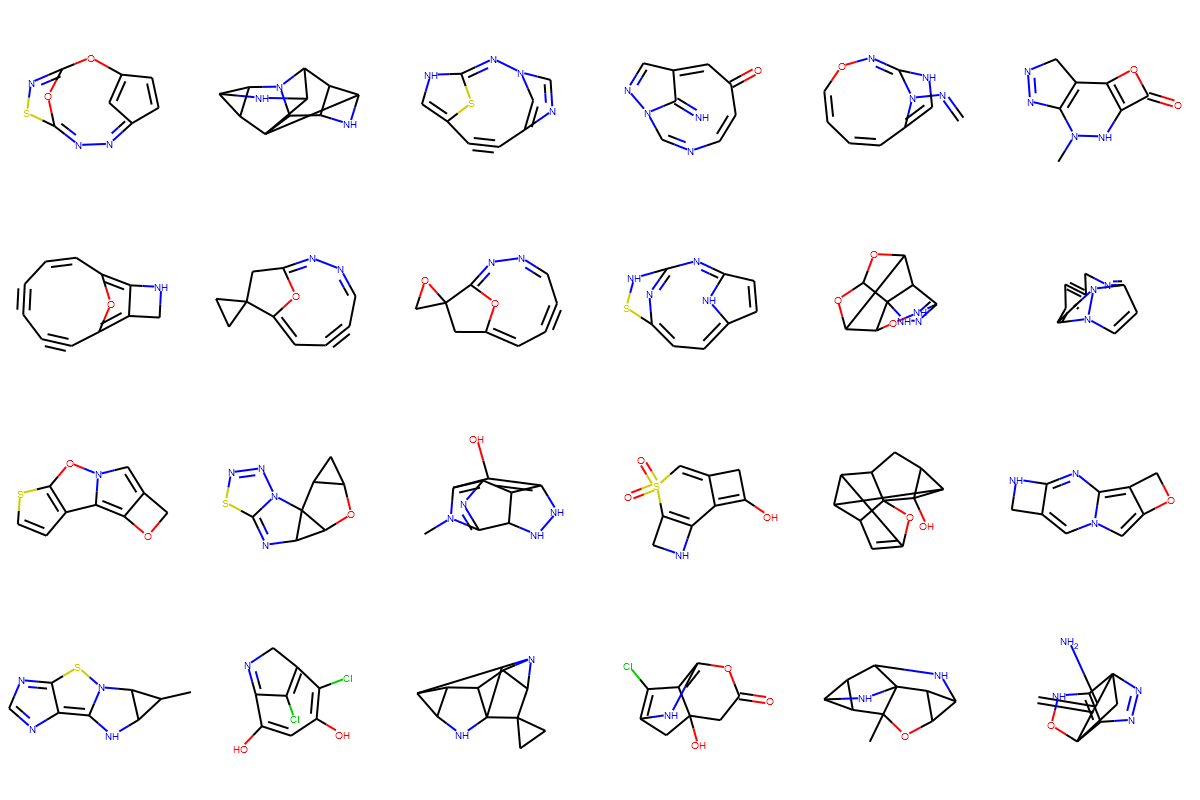

In [8]:
Draw.MolsToGridImage(mols[:24], molsPerRow=6)


In [9]:

def getEDM(mol):
    #get 3d coords
    m3 = Chem.AddHs(mol)
    embed = AllChem.EmbedMolecule(m3)
    if embed+1:  
        m3 = Chem.RemoveHs(m3)
        conformer = m3.GetConformer(0)
        positions = conformer.GetPositions()
        return positions
    else:
        return None

In [10]:
edms = list()
atomidx = list()
for m in tqdm_notebook(mols[:1000]):
    points = getEDM(m)
    if points is None:
        None
    else:
        edm = pdist(points)
        edms.append(edm)
        
        atoms = np.array([i.GetAtomicNum() for i in m.GetAtoms()])
        atomidx.append(atoms)

In [11]:
##Padding the EDM should make this method scale to an arbitrary number of atoms

def pad(array, reference_shape, offsets):
    """
    array: Array to be padded
    reference_shape: tuple of size of ndarray to create
    offsets: list of offsets (number of elements must be equal to the dimension of the array)
    will throw a ValueError if offsets is too big and the reference_shape cannot handle the offsets
    """
    # Create an array of zeros with the reference shape
    result = np.zeros(reference_shape)
    # Create a list of slices from offset to offset + shape in each dimension
    insertHere = [slice(offsets[dim], offsets[dim] + array.shape[dim]) for dim in range(array.ndim)]
    # Insert the array in the result at the specified offsets
    result[insertHere] = array
    return result

In [12]:
square_edm=list()
index=0
for edm in edms:
  ##represent atoms as atomic number and tack them onto the EDM, the GAN shouldnt care about the scale
  sq_edm=np.column_stack((squareform(edm),atomidx[index]))
  sq_edm=pad(sq_edm, (28,28), [0,0])
  square_edm.append(sq_edm)
  index+=1

c:\users\harry\.conda\envs\tf_gpu_tensor\lib\site-packages\ipykernel_launcher.py:13: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  del sys.path[0]


(28, 28)


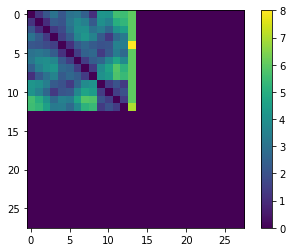

In [32]:

data_new = np.array(square_edm[1])

print(data_new.shape)

plt.imshow(data_new)
plt.colorbar()

In [13]:
infogan = INFOGAN()
# infogan.train(epochs=50000, batch_size=128, sample_interval=50)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 6272)              457856    
_________________________________________________________________
reshape (Reshape)            (None, 7, 7, 128)         0         
_________________________________________________________________
batch_normalization_3 (Batch (None, 7, 7, 128)         512       
_________________________________________________________________
up_sampling2d (UpSampling2D) (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 14, 14, 128)       147584    
_________________________________________________________________
activation (Activation)      (None, 14, 14, 128)       0         
_________________________________________________________________
batch_normalization_4 (Batch (None, 14, 14, 128)      

In [ ]:
infogan.train(epochs=900000, batch_size=1, sample_interval=50)

0 [D loss: 0.00, acc.: 100.00%] [Q loss: 0.00] [G loss: 0.01]
1 [D loss: 0.00, acc.: 100.00%] [Q loss: 0.00] [G loss: 0.00]
2 [D loss: 0.00, acc.: 100.00%] [Q loss: 0.00] [G loss: 0.00]
3 [D loss: 0.00, acc.: 100.00%] [Q loss: 0.00] [G loss: 0.00]
4 [D loss: 0.00, acc.: 100.00%] [Q loss: 0.00] [G loss: 0.00]
5 [D loss: 0.00, acc.: 100.00%] [Q loss: 0.00] [G loss: 0.01]
6 [D loss: 0.00, acc.: 100.00%] [Q loss: 0.01] [G loss: 0.00]
7 [D loss: 0.00, acc.: 100.00%] [Q loss: 0.09] [G loss: 0.00]
8 [D loss: 0.00, acc.: 100.00%] [Q loss: 0.03] [G loss: 0.54]
9 [D loss: 0.00, acc.: 100.00%] [Q loss: 0.04] [G loss: 0.00]
10 [D loss: 0.00, acc.: 100.00%] [Q loss: 0.15] [G loss: 0.00]
11 [D loss: 0.00, acc.: 100.00%] [Q loss: 0.15] [G loss: 0.00]
12 [D loss: 0.00, acc.: 100.00%] [Q loss: 0.08] [G loss: 0.00]
13 [D loss: 0.00, acc.: 100.00%] [Q loss: 0.00] [G loss: 0.00]
14 [D loss: 0.00, acc.: 100.00%] [Q loss: 0.01] [G loss: 0.00]
15 [D loss: 0.00, acc.: 100.00%] [Q loss: 0.02] [G loss: 0.00]
16

129 [D loss: 0.00, acc.: 100.00%] [Q loss: 0.00] [G loss: 0.01]
130 [D loss: 0.00, acc.: 100.00%] [Q loss: 0.00] [G loss: 0.01]
131 [D loss: 0.00, acc.: 100.00%] [Q loss: 0.00] [G loss: 0.10]
132 [D loss: 0.00, acc.: 100.00%] [Q loss: 0.00] [G loss: 0.02]
133 [D loss: 0.00, acc.: 100.00%] [Q loss: 0.00] [G loss: 0.01]
134 [D loss: 0.00, acc.: 100.00%] [Q loss: 0.00] [G loss: 0.00]
135 [D loss: 0.00, acc.: 100.00%] [Q loss: 0.03] [G loss: 0.00]
136 [D loss: 0.00, acc.: 100.00%] [Q loss: 0.00] [G loss: 0.00]
137 [D loss: 0.00, acc.: 100.00%] [Q loss: 0.06] [G loss: 0.01]
138 [D loss: 0.00, acc.: 100.00%] [Q loss: 0.01] [G loss: 0.00]
139 [D loss: 0.00, acc.: 100.00%] [Q loss: 0.26] [G loss: 0.00]
140 [D loss: 0.00, acc.: 100.00%] [Q loss: 0.00] [G loss: 0.00]
141 [D loss: 0.00, acc.: 100.00%] [Q loss: 0.00] [G loss: 0.00]
142 [D loss: 0.00, acc.: 100.00%] [Q loss: 0.00] [G loss: 0.07]
143 [D loss: 0.00, acc.: 100.00%] [Q loss: 0.01] [G loss: 0.00]
144 [D loss: 0.00, acc.: 100.00%] [Q los

257 [D loss: 0.00, acc.: 100.00%] [Q loss: 0.20] [G loss: 0.00]
258 [D loss: 0.00, acc.: 100.00%] [Q loss: 0.00] [G loss: 0.00]
259 [D loss: 0.00, acc.: 100.00%] [Q loss: 0.00] [G loss: 0.00]


In [16]:
infogan.save_model()

In [41]:
sampled_noise, _ = infogan.sample_generator_input(1)

In [42]:

label = to_categorical(np.full(fill_value=0, shape=(1,1)), num_classes=infogan.num_classes)


In [43]:
gen_input = np.concatenate((sampled_noise, label), axis=1)
gen_imgs = infogan.generator.predict(gen_input)


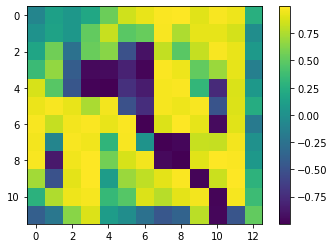

In [54]:

##very noisy after two hours training on laptop
##molecule size is variable so need a better way to extract the EDM from padding than just eyeballing it
plt.imshow(gen_imgs[0][:12,:12].reshape(12,12))
plt.colorbar()


In [56]:
atom_ids=gen_imgs[0][:,13]

In [58]:
atom_ids

array([[2.35227749e-01],
       [2.14083940e-01],
       [3.53495061e-01],
       [2.59817719e-01],
       [2.22413242e-01],
       [1.51405007e-01],
       [6.71629533e-02],
       [2.12801937e-02],
       [2.58602500e-01],
       [3.75989918e-03],
       [6.88828435e-03],
       [4.23458040e-01],
       [3.20285499e-01],
       [3.77742499e-02],
       [4.46590409e-03],
       [6.19363692e-03],
       [2.05891654e-02],
       [4.43488825e-03],
       [2.05157697e-02],
       [1.52003495e-02],
       [1.06989089e-02],
       [9.11578536e-06],
       [1.87834427e-02],
       [1.16140870e-02],
       [1.57513898e-02],
       [4.14949888e-03],
       [3.43059562e-02],
       [6.29528100e-03]], dtype=float32)